#### Parte I - Análisis de la base de hogares y cálculo de pobreza

##### 1. Analisis exploratorio


Comezamos pensando, solo intuitvamente cuales a priori son las variables que podrian ser utilies para predecir la pobreza y perfeccionar las estimaciones el TP2:

Dentro de la varibles en la encuesta de hogares consideramos relevantes las caracterisicas de la vivienda:
* El tipo de vivienda (IV1)
* Cantidad de habitaciones (IV2)
* Material del techo (V4)
* Revestimiento del techo (IV5)
* Tipo de conexion a agua (IV6 y IV7)
* Tener baño (IV8), tipo de baño (IV9) y equipamiento (IV10)
* Tipo de desague (IV11)
* Zona de ubicacion: cercano a basural (IV12_1), zona inundable (IV12_2) y/o villa de emergecia (IV12_3)


Las caractersiticas habitacionales:
* Cantidad de ambientes (II1)
* Cantidad de dormitorios (II2)
* Habitaccion para trabajo (II3), exlusivamente (II6)
* Tienen: cuarto de cocina (II4_1), lavadero (II4_2), garage (II4_3), cuantos de estos se usan para dormir (II5).
* Regimen de tenencia (II7)
* Combustible para cocinar (II8)
* Propiedad del baño (II9)

Variables de tipo de ingresos: V1 a 18. Y variables de trabajo infantil: V19_A y V19_B

Integrantes del hogar: total (IX_Tot) y menores de 10 (IX_men10).

No icluimos las que son mediciones de ingresos al igual que en el TP2.





2. Continuamos descargando la base de hogares y cargandola

In [1]:
#Importamos las librerias necesarias
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm     
import warnings
warnings.filterwarnings('ignore')

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, average_precision_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from scipy.special import expit



# Definimos el directorio
# os.chdir('C:/Users/rodri/OneDrive/Escritorio/Maestría/Big Data/BigData/TP3')
os.chdir('C:/Users/Usuario/Desktop/MAESTRIA/Big Data/TPs/BigData/TP3')

In [2]:
# Cargamos los datos, menteniendo solo las observaciones para el Gran Buenis Aires y la Ciudad de Buenos Aires:
hogares = pd.read_excel("inputs/usu_hogar_T123.xlsx")
hogares = hogares[(hogares['AGLOMERADO']==32) | (hogares['AGLOMERADO']==33)]
individual = pd.read_excel("inputs/usu_individual_T123.xlsx")
individual = individual[(individual['AGLOMERADO']==32) | (individual['AGLOMERADO']==33)]

3. Unimos la tablas de Individuos y hogares

In [3]:
# Chequeamos que columnas estan duplicadas para que no se nos duplique en el merge
columnas_duplicadas = set(hogares.columns).intersection(set(individual.columns))
# Removemos CODUSU y NRO_HOGAR de la lista, para mantenerlas como ids del merge
columnas_duplicadas.remove("CODUSU")
columnas_duplicadas.remove("NRO_HOGAR")
# Eliminamos los duplicados de la base hogar
hogares.drop(columnas_duplicadas, axis=1, inplace=True)

# Hacemos el left join de los hogares con los individuos
df = pd.merge(individual,hogares, on=["CODUSU", "NRO_HOGAR"], how="left")


4. Herramientas de limpieza de datos

Para la limpieza utilizaremos las herramientas que nos ofrece el modulo `pandas`, para el manejo de DataFrames. A continuación, explicaré las funciones que se están utilizando:

   - la función `describe()` proporciona información resumida sobre la distribución de valores en esa columna. Incluyendo la media, minimo, desviación estánda, cuartiles, etc.

   - `isnull()` es un método de los DataFrames de pandas que devuelve una matriz booleana indicando las ubicaciones de los valores faltantes en el DataFrame.

   - `dropna()` es un método de los DataFrames de pandas que elimina las filas o columnas con valores faltantes.

   - La función `fillna()` se utiliza para rellenar los valores faltantes en la columna.

   - La función `drop()` con `axis=1`, elimina una columna inidicada.

   -  La función `duplicated()` es un método de pandas que devuelve una Serie de valores booleanos que indica si cada fila del DataFrame es una duplicada de una fila anterior. Con `sum()` contamos estos booleanos generado de modo de obtener la cantidad de duplicados.


5. Limpieza de Datos

In [4]:
# Hacemos un cheaqueo rapido de los datos, generando una tabla de estadisticas descriptivas
descripcion = df.describe()

In [5]:
# Chequeamos que no haya duplicados
df.duplicated().sum()

0

In [6]:
#Chequeamoss el porcentaje de missing values
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph

,Columna,Porcentaje de NAs
CODUSU,CODUSU,0.0
ANO4,ANO4,0.0
TRIMESTRE,TRIMESTRE,0.0
NRO_HOGAR,NRO_HOGAR,0.0
COMPONENTE,COMPONENTE,0.0
...,...,...
VII1_2,VII1_2,0.0
VII2_1,VII2_1,0.0
VII2_2,VII2_2,0.0
VII2_3,VII2_3,0.0


In [7]:

# Eliminimamos la varaible si esta tiene mas de 90% de percent_missing
df = df.dropna(thresh=len(df)*0.9, axis=1)
# Chequeamos nuevamente los missing
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_eph = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
# Remplazamos los missings en CH08 (cobertura medica) por 9 = Ns/Nc
df['CH08'] = df['CH08'].fillna(9)
# Reempalazamos el 9 por 0
df['CH08'] = df['CH08'].replace(9,0)

# Consideramos que el que sea missing brinda informacion relevante, por lo que lo dejamos como una categoria mas

# De este modo no tenemos mas NAs

In [8]:
# Cheaqueamos que no existan ingresos negativos
df['ITF'].describe()


count    7.619000e+03
mean     1.384079e+05
std      3.349417e+05
min      0.000000e+00
25%      0.000000e+00
50%      7.500000e+04
75%      2.000000e+05
max      1.099000e+07
Name: ITF, dtype: float64

In [9]:
# eliminamos observaciones con datos NS/NC en la variable para cantidad de habitaciones 
df = df[(df['IV2'] < 99)]

# Remplazamos las que son NS/NR por 0
df['CH11'] = df['CH11'].replace(9,0)
df['CH13'] = df['CH13'].replace(3,0)
df['CH15'] = df['CH15'].replace(9,0)
df['CH16'] = df['CH16'].replace(9,0)
df['NIVEL_ED'] = df['NIVEL_ED'].replace(9,0)
df['CAT_OCUP'] = df['CAT_OCUP'].replace(9,0)
# Al hacer esto mo perdemos la observacion.


In [10]:
# Ahora vamos a crear las variables dummy para las categoricas
for col in ['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'DECCFR', 'CH09', 'CH10', 'CH11', 'CH12']:
    df[col] = df[col].astype('category')

In [11]:
#Hacemos un ultimo check de missings
percent_missing1 = df.isnull().sum() * 100 / len(df)
missing_value_eph1 = pd.DataFrame({'Columna': df.columns,
                                 'Porcentaje de NAs': percent_missing})
missing_value_eph1

,Columna,Porcentaje de NAs
CODUSU,CODUSU,0.0
ANO4,ANO4,0.0
TRIMESTRE,TRIMESTRE,0.0
NRO_HOGAR,NRO_HOGAR,0.0
COMPONENTE,COMPONENTE,0.0
...,...,...
VII1_2,VII1_2,0.0
VII2_1,VII2_1,0.0
VII2_2,VII2_2,0.0
VII2_3,VII2_3,0.0


6. Estadisticas descriptivas

A continuación presentamos las estadisticas descriptivas, de cinco variable de la encuesta de hogares que consideramos relevantes: Total  de integrantes del hogar(IX_Tot), integrantes menores de 10 años (IX_men10), cantidad de habitaciones (IV2), vivienda en zona inundable (IV12_2), y cantidad de ambientes de hogar (II1)

In [19]:
# Varaibles de interes
variables_interes = df[['CODUSU','IX_TOT', 'IX_MEN10', 'IV2', 'IV12_2', 'II1']]
# Renombrar variables
variables_interes = variables_interes.rename(columns={'IX_TOT':'N de integrantes', 'IX_MEN10':'N menores de 10', 'IV2':'cantidad habitaciones', 'IV12_2':'en zona inundable', 'II1':'N de ambientes'})

# mantenemos solo una observacion por hogar
variables_interes = variables_interes.drop_duplicates(subset=['CODUSU'], keep='first')
# drop codusu
variables_interes = variables_interes.drop(['CODUSU'], axis=1)

In [20]:

variables_interes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
N de integrantes,2723.0,2.783694,1.594857,1.0,2.0,2.0,4.0,13.0
N menores de 10,2723.0,0.345575,0.712493,0.0,0.0,0.0,0.0,8.0
cantidad habitaciones,2723.0,2.881014,1.124088,1.0,2.0,3.0,3.0,9.0
en zona inundable,2723.0,1.923614,0.265664,1.0,2.0,2.0,2.0,2.0
N de ambientes,2723.0,2.867058,1.120557,0.0,2.0,3.0,3.0,8.0


Podemos ver que para los 2723 hogare en la encuesta, en promedio casi 3 integrantes por hogar, y que aproximadamente solo uno de cada tres hogares tienen un niño menor a 10 años. En promedio hay casi 3 ambientes y habitaciones por hogar, y solo el 2% de los hogares se encuentran en zonas inundable.

7. Calculo de Adulto Equivalente y Requerimentos del Hogar

In [13]:
# Cargaos la tabla de equivalencia de adultos
adulto_equiv_data = pd.read_excel("inputs/tabla_adulto_equiv.xlsx")

# melt adulto_equiv_data Muejeres y Hombres
adulto_equiv_data = pd.melt(adulto_equiv_data, id_vars=['Edad'], value_name= 'adulto_equiv')


In [14]:

# Change values of variable column to 1 if Hom and 2 if Muj
adulto_equiv_data['variable'] = np.where(adulto_equiv_data['variable']=='Mujeres', 2, 1)
# Rename variable column to Sexo
adulto_equiv_data = adulto_equiv_data.rename(columns={'variable': 'Sexo'})

#Función que lee los valores de edad en números CH06 y me lo impacta en la categoría etarea correspondiende de la nueva tabla.
def rango_edad(edad):
    if edad < 0:
        rangoetareo = "Menor de 1 años"
    elif edad > 0 and edad < 18:
        rangoetareo = str(edad)+" años"
    elif 17 < edad and edad < 30:
        rangoetareo = "18 a 29 años"
    elif 29 < edad and edad < 46:
        rangoetareo = "30 a 45 años"
    elif 45 < edad and edad < 61:
        rangoetareo = "46 a 60 años"
    elif 60 < edad and edad < 76:
        rangoetareo = "61 a 75 años"
    elif edad > 75:
        rangoetareo = "más de 75 años"
        
    else:
        rangoetareo = 'NaN'
    return rangoetareo

#Aplico la función a mi tabla para crear la columna deseada
df['rango_etareo'] = df['CH06'].apply(rango_edad)


#Renombro la columna "edad", igual que la de la otra tabla
df = df.rename(columns={'rango_etareo': 'Edad'})
df = df.rename(columns={'CH04': 'Sexo'})

# Mejoramos la funcion de match en relacion al TP2 donde los match para los menores de 1 año no estaban bien definidos.



In [15]:

# Hacemos el merge de las dos tablas
df = df.merge(adulto_equiv_data, on=['Sexo','Edad'], how='left')
#Sumo para las personas de un mismo hogary loguardo como ad_equiv_hogar
df['ad_equiv_hogar'] = df.groupby('CODUSU')['adulto_equiv'].transform('sum')



8. Particiones segun respuesta y ingreso necesario

In [16]:
# Punto 1.3: Particionamos la muestra segun respondieron o no sobre los ingresos:
respondieron = df[df['ITF'] > 0]
respondieron = respondieron.reset_index(drop=True)
norespondieron = df[df['ITF'] <= 0]
norespondieron = norespondieron.reset_index(drop=True)

In [17]:

# Punto 1.4: Agregar columna que indica el ingreso necesario del hogar para no ser pobre
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'] * 53371.05


9. Generamos una indicadora de persona pobre

In [18]:

# Punto 1.4: Columna que indica si una persona es pobre según el ingreso de su hogar
respondieron.loc[:, 'pobre'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)
mean_pobres = respondieron['pobre'].mean()
print(mean_pobres)


0.34947768281101615


10. Calculo de pobreza por hogares (muestra expandida)

In [19]:
# Calaculamos la tasa de pobreza de hogares, expondiendo la muestra con el ponderador de hogares, PONDIH.
# Columna indicadora de pobreza de hogares
respondieron.loc[:, 'pobre_hogar'] = (respondieron['ingreso_necesario'] > respondieron['ITF']).astype(int)

# Tasa de pobreza de hogares (sin expandir)
mean_pobres_hogar_temp = respondieron['pobre_hogar'].mean()
print(mean_pobres_hogar_temp)


0.34947768281101615


In [20]:
# Ponderar los hogares pobres
respondieron['pobre_hogar_ponde'] = respondieron['PONDIH'] * respondieron['pobre_hogar']


# Tasa de pobreza de hogares
mean_pobres_hogar = respondieron['pobre_hogar_ponde'].sum() / respondieron['PONDIH'].sum() 
print(mean_pobres_hogar)

0.3739120497806356


Encontramos que la pobreza en nuestro calculo es solo del 37.39% para el Gran Buenos Aires y la Ciudad de Buenos Aires. Mientras que en el TP2, la pobreza era del 31,5% para el Gran Buenos Aires, las diferencias podrian deberse a las correcciones realizadas en el merge y la limpieza de los datos. 

Esta estimacion, aunque es cercana, es mayor al dato publicado en el informe de INDEC el cual da un numero de 30.3%.

#### Parte II - Construcción de funciones

1. Función evalua_metodo(model, x_train, y_train, x_test, y_test)

In [21]:
def evalua_metodo(model, x_train, y_train, x_test, y_test):
    '''
    La función recibe como inputs: el modelo, toma las matrices de datos de train y test.
    A parte de esto realiza las estimaciones, y devuelve las diferentes medidas de precision: accuracy, matriz de confusión y sus componentes (verdadero negativo, falspo positivo, falso negativo, verdadero positivo), área bajo la curva ROC, ECM y el Average Precision Score (AP). 

    '''
    
    modelofit = model.fit(x_train, y_train)
    y_pred = modelofit.predict(x_test)
    y_pred = np.where(y_pred > 0.5, 1, y_pred)
    y_pred = np.where(y_pred <= 0.5, 0, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    tn, fp , fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    ecm = mean_squared_error(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)

    return (accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap,modelofit)

2. Funcioón cross_validatio(model, k, x, y)

In [22]:
def cross_validation(model, k, x, y):
    '''
    La función recibe como inputs: el modelo, las matrices de datos de variables explicativas y el vector de la variable objetivo, a partir de lo cual divide los datos en train y test.
    Ademas recibe un parametro "k" que es la cantidad de iteraciones a realizarse en k-fold CV. 

    A partir de esto, realiza las estimaciones, y devuelve las diferentes métricas de precisión para cada una de las particiones analizadas:
    es una colección del K, accuracy, ECM, AP y el modelo analizado. 

    ** utiliza la funcion evalua_metodo ***

    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=10)
    resultados = pd.DataFrame(columns=["K", "accuracy", "ecm", "ap", "auc", "modelo"]) 
    for i, (train_index, test_index) in enumerate(kf.split(x)):   
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
        X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
        
        accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(model, X_train_transformed, y_train, X_test_transformed, y_test)
        K = i+1
        resultados = resultados._append({"K":i+1, "accuracy":accuracy, "ecm":ecm, "ap":ap, "auc": auc, "modelo":modelofit}, ignore_index=True)
    return (K, accuracy, auc, ecm, ap, model)

3. Función evalua_config(landa, k, x, y, l1_ratio=1)

In [23]:
def evalua_config(modelo, lambdas, x, y,penalty1,k_range):
    '''
    La función tiene itera entre los distintos valores de lambda del modelo Logit para los valores de K.
    
    Devuelve el valor de lambda que minimiza el ECM de la regresión. 
    
    Toma de input: el modelo, la grilla con los valores de los lambda a iterar, las matrices de datos de X e Y.
    
    Ademas se indica el penalty elegido para Logit (l1 = LASSO, l2 = Ridge) y el valor de K (numero de iteraciones de K-fold CV) 
    
    El output es el valor que toma el ECM para el lambda que minimiza esta medida y el valor para este hiperparámetro.
    '''
    ecms =  pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    
    if modelo == "logit":
    
        for i in lambdas:
            for k11 in k_range:
                C_alpha = 1/i
                model = LogisticRegression(penalty = penalty1, C = C_alpha, max_iter=1000, solver="saga")
                k, accuracy, auc, ecm, ap, modelo = cross_validation(model,k11,x,y)
                ecms = ecms._append({"alp":i, "ecm":ecm, "K": k,"penalty":penalty1}, ignore_index=True)
    ecms_avg = ecms.groupby('alp').agg({'ecm':'mean'}).reset_index()
    min_ecm = np.Inf
    alp_ecm = None
    for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                alp_ecm = row['alp']
    return (ecms,min_ecm,alp_ecm)

4. Función evalua_multples_metodos(k_cv,k_knn, landa_max, x_train, x_test , y_train, y_test, x, y)

In [24]:

def evalua_multiples_metodos(modelos, x, y, parametros):
    '''
    
    El output de la función, por su parte, es una tabla que indica el modelo analizado, 
    los valores de sus parámetros y las medidas de Accuracy, ECM, AP, AUC y la Matriz de Confusión.

    El propósito de esta función es generar una tabla que contiene métricas descriptivas relacionadas con el rendimiento de diversos modelos.
     Estas métricas se basan en los hiperparámetros especificados y/o la configuración proporcionada por el usuario al llamar a la función.
      Para lograr esto, se requiere un primer conjunto de información en forma de un diccionario que identifica los modelos que se ejecutarán,
       tales como KNN para el modelo de vecinos más cercanos, LDA para el modelo de análisis de discriminante lineal y Logit para el modelo de regresión logística.
        En segundo lugar, se debe especificar los conjuntos de datos que contienen las variables x e y que se utilizarán en los modelos.

    Por último, es esencial proporcionar otro diccionario que incluye el hiperparámetro alfa (lambda) para el modelo Logit,
     junto con su correspondiente configuración de parámetros. Esto último se aplica también a KNN y LDA. 

    En cuanto a los parámetros de la función,
     para optimizar el valor de lambda de la regularización,
      se deben incluir en el diccionario "parametros" diferentes valores de lambda que se iterarán en busca de minimizar el Error Cuadrático Medio (ECM).
       También es necesario especificar la cantidad de particiones que se desean probar en la validación cruzada (CV) a través del campo "k_range" en el input "parametros",
        que puede ser un entero o un rango de valores. Lo mismo se aplica a los campos "neighbors" para la cantidad de vecinos en KNN y "components" para los componentes en LDA.

    Si se pretende ejecutar un modelo Logit, es imperativo indicar el campo "penalty" en "parametros" mediante una lista que contemple distintas penalidades a analizar,
     donde los valores l1 y l2 corresponden a LASSO y Ridge, respectivamente.

    En cuanto al resultado de la función, se obtiene una tabla que muestra el modelo analizado, los valores de sus parámetros y diversas medidas de rendimiento,
     como precisión, ECM, Puntaje Promedio de Precisión (AP), Área Bajo la Curva (AUC), y la Matriz de Confusión.
    
        
    '''
    tabla =  pd.DataFrame(columns=["Modelo", "Neighbors", "Components", "Penalty", "Alp_best", "Accuracy", "ECM", "AP", "AUC", "Verdadero 0", "Falso 1", "Falso 0", "Verdadero 1"])
    ecms_p = pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    for modelo in modelos:
        if modelo == "KNN":
            neighbors= parametros["neighbors"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit=evalua_metodo(KNeighborsClassifier(n_neighbors=neighbors),x_train,y_train,x_test,y_test)
            tabla = tabla._append({"Modelo":modelo, "Neighbors": neighbors,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "LDA":
            components= parametros["components"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LinearDiscriminantAnalysis(n_components=components),x_train,y_train,x_test,y_test)
            tabla = tabla._append({"Modelo":modelo, "Components": components,"Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif modelo == "Logit":
            for p in parametros["penalty"]:
                ecms, min_ecm, alp_ecm = evalua_config("logit",parametros["lambda"],x,y,p, parametros["k_range"])
                sc = StandardScaler()
                X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
                X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
                accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, modelofit = evalua_metodo(LogisticRegression(penalty = p, C = 1/alp_ecm, max_iter=1000, solver="saga"),x_train,y_train,x_test,y_test)
                tabla = tabla._append({"Modelo":modelo, "Penalty": p,"Alp_best": alp_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
                ecms_p = ecms_p._append(ecms)
    tabla = tabla.fillna('')
    return [tabla,ecms_p]

#### Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar. A su vez, incluiremos ejercicios de regularización y de validación cruzada.

##### Ejercicio 1 

Elminamos de ambas bases, respondieron y no respondieron, todas las variables relacionadas a ingresos. Y las variables temporales para los calculos de la Parte I.

In [25]:
# Eliminamos las variables relacionadas a ingresos y las columnas de las bases respondieron/no respondieron
respondieron = respondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
respondieron = respondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
respondieron = respondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
respondieron = respondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
respondieron = respondieron.drop(['IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
respondieron = respondieron.drop(['adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario
# Eliminamos variable de idice y creadas a fines de la primera parte:
respondieron = respondieron.drop(['CODUSU','ANO4','TRIMESTRE','NRO_HOGAR','COMPONENTE','CH05','MAS_500',"REGION","PONDERA",'PONDIIO','PONDII','PONDIH','REALIZADA','Edad','pobre_hogar_ponde'], axis=1) 



norespondieron = norespondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
norespondieron = norespondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR',  'ADECINDR'], axis=1) # ingresos total individual
norespondieron = norespondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
norespondieron = norespondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
norespondieron = norespondieron.drop(['IPCF', 'DECCFR',  'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
norespondieron = norespondieron.drop(['adulto_equiv', 'ad_equiv_hogar'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario
# Eliminamos variable de idice y creadas a fines de la primera parte:
norespondieron = norespondieron.drop(['CODUSU','ANO4','TRIMESTRE','NRO_HOGAR','COMPONENTE','CH05','MAS_500',"REGION","PONDERA",'PONDIIO','PONDII','PONDIH','REALIZADA','Edad'], axis=1)

Establecemos la variable pobreza como dependiente, $y$, y las variables independientes, $x$, como todas las demas variables de la encuesta.

In [26]:
y = respondieron['pobre']
# Nos quedamos con las variables de la base que nos sirven para hacer la regresion
x = respondieron.drop(['pobre','pobre_hogar'], axis=1)

x = sm.add_constant(x) # Agregamos la columna de unos.
x=x.astype('int')
y=y.astype('int')


##### Ejercicio 2

A continuacion corremos la funcion `evalua_multiples_metodos` sobre la base de respondieron.

Tomaos valor de lambda 2 y 3, y elgimos hiperparametros: 

- "neighbors" : 5, 
- "components" : 1,
-  k_range : range(2,3)

In [27]:
modelos = ["KNN","LDA","Logit"]

parametros = {"k_range": range(2,3), "neighbors":5, "components":1, "penalty": ["l1","l2"], "lambda": [2,3]} #Penalty de Lasso, la l2 es Ridge. 

lasso_2 = evalua_multiples_metodos(modelos,x,y,parametros)
                                                 
lasso_2[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.779359,0.220641,0.542034,0.726933,498,68,118,159
1,LDA,,1,,,0.822064,0.177936,0.617725,0.783620,507,59,91,186
2,Logit,,,l1,2.0,0.822064,0.177936,0.618321,0.787307,503,63,87,190
3,Logit,,,l2,3.0,0.819692,0.180308,0.614281,0.785540,501,65,87,190


El metodo que mejor se comporta es el de regresion logistica con $\lambda$ de 2 y LDA, con un mismo ECM de 0.177936, aunque el area bajo la curva ROC es mayor para el logit. La cantidad e verdaderos positivos es mayor para el logit, pero la cantidad de falsos positivos es mayor para LDA. Sin embargo, las diferencia son marginales, por lo tanto, ambos metodos son igualmente buenos.

In [28]:
lasso_2[1]


,alp,ecm,K,penalty
0,2,0.181861,2,l1
1,3,0.183761,2,l1
0,2,0.181861,2,l2
1,3,0.181387,2,l2


Se puede observar, bajo esta especificaionm, el ECM difiere a diferentes valores de $\lambda$. Siendo el valor de $\lambda$ igual a 3 el de menor ECM para el modelo ridge, $\lambda$ igual a 2 para LASSO.

##### Ejercicio 3 

Al momento de elegir $\lambda$ por validación cruzada debemos partir la base de datos en K particiones, cuanto más grande sea K, mayor será la cantidad de iteraciones que se usarán para entrenar al modelo. Este proceso de K- Fold-Cross-Validation lo que hace es obtener la configuración del parámetro que minimice el error de pronostico del modelo y nos quedaríamos con el que tenga el mínimo error de pronóstico por cross validation.

En palabras más sencillas, dado un potencial valor de $\lambda$, este algoritmo se encarga de estimar K veces los modelos examinados sobre K submuestras de los datos de entrenamiento, dejando en cada caso una porción de los datos disponible para el testeo del modelo. Se almancenan las estimaciones de ECM  (o cualquier otra métrica de capacidad predictiva- de cada iteración), y finalmente se promedia. Después de esto, se repite el procedimiento para todos los valores de $\lambda$ que se quiera probar y el $\lambda$ elegido es aquel de menor ECM promedio. 



Notar que en ningún momento el algoritmo utiliza a la base de test. Esto aumentaría el riesgo de overfitting. La idea es que la base de testing quede reservada para decirnos que tan bueno es nuestro modelo final en datos que nunca se utilizaron para su estimación. Esto nos permite ver cómo se comportarían los modelos examinados al agregar data nueva, como pasaría en una situación real. En cambio, si estimáramos el $\lambda$ ya usando la base de test, el parametro sería elegido para reducir el error en esta misma base, lo que sería tautologico y no sería informativo sobre cuan bien esta configuración predeciría usando nueva data.

#### Ejercicio 4

El problema de usar un K muy pequeño es que se minimiza la base de test es decir, si uso un K=2 usamos 50% de los datos para train y 50% de los datos para test. A un K menor, el entrenamiento del modelo sera menos exigente, por lo que la precision del modelo sera menor.

Por otro lado, si usamos un K muy grande, maximizariamos la base de train pero con un costo computacional alto. Un problema que puede surgir es que la estimación del error en la base de test es más sensible a valores particulares como por ejemplo outliers. 

Por último, si elegimos un K=n, el modelo se estima n veces usando n-1 observaciones y se testea contra cada una de las observaciones. En todos los casos el modelo se estima K veces, la diferencia radica en que valor toma ese K. 

#### Ejercicio 5

Ahora realizmaos el barrido en $\lambda = 10^n$ con $n \in \{-5,-4,\ldots,0\ldots,4,5\}$, y utilizamos 10 fold CV para elegir el $\lambda$ óptimo.

In [29]:
# Definimos los métodos que vamos a estimar y los hiperparamtros.
modelos = ["KNN","LDA","Logit"]
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l1"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Lasso, la l2 es Ridge. 

# Estimamos
reg_lasso = evalua_multiples_metodos(modelos,x,y,parametros)

In [30]:
# Mostramos los resultados para LASSO.
reg_lasso[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.779359,0.220641,0.542034,0.726933,498,68,118,159
1,LDA,,1,,,0.822064,0.177936,0.617725,0.783620,507,59,91,186
2,Logit,,,l1,1.0,0.822064,0.177936,0.618321,0.787307,503,63,87,190


In [68]:
# Mostamos el ECM para los diferentes valores de lambda.

tabla_min_ecm = reg_lasso[1]
tabla_min_ecm

COMENTARIO: Si inspeccionamos la tabla que nos muestra los diferentes ECM para los diferentes valor $\lambda$ y K. Podemos ver que valor que no esta tomando como minimo dado el K tomado, es un minimo local.

El minimo global esta no esta en un unico valor, para K = 3 (que es el K que minimiza siempre), el ECM para los valores 0.00001,0.0001 y 0. 001 tiene el ECM minimo e igual. No estamos seguro, pero creemos que hay una posibilidad de que, por alguna razon, el algoritmo esta cayendo el el minimo local de $\lambda$ = 1, y no en el minimo global.

In [32]:
parametros = {"k_range": range(2,11), "neighbors":5, "components":1, "penalty": ["l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Ridge. 

reg_ridge = evalua_multiples_metodos(modelos,x,y,parametros)

In [33]:
reg_ridge[0]

,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,KNN,5,,,,0.779359,0.220641,0.542034,0.726933,498,68,118,159
1,LDA,,1,,,0.822064,0.177936,0.617725,0.783620,507,59,91,186
2,Logit,,,l2,0.00001,0.820878,0.179122,0.616471,0.787345,501,65,86,191


El valor de λ elegido para cada caso es de 1 para el caso de Lasso y 0.0001 para el caso de Ridge. A su vez, en los box plots mostrados a continuación puede observarse que los menores valores de ECM se encuentran para los valores más chicos de $\lambda$, dándose un salto discreto considerable entre los valores 100 y 1000 en LASSO y dos saltos diferentes en Ridge, un primer salto para valores entre 1000 y 10000 y  otro  salto para valores entre 10000 y 100000.

Los box-plots nos muestran que el ECM se comporta de manera muy similar en los dos métodos. Hasta un $\lambda$ de 100, el ECM promedio para las K particiones se mantiene por debajo de 0.23, aunque el despegue en Lasso se da antes que en Ridge, con un $\lambda$ de 100, mientras que en Ridge, el primer salto más discreto se da con un $\lambda$ de 1000. 
 
Otra diferencia entre los dos métodos es que cuando $\lambda$ llega a 1000, el ECM promedio en Lasso salta directamente a un nivel alrededor de 0.36, mientras que en Ridge su primer salto es más cercano 0.32 y su segundo salto más cercano a 0.37. Es decir a partir de 100000, los dos métodos llegan a un valor cercano a 0.37 y se mantiene constante .  



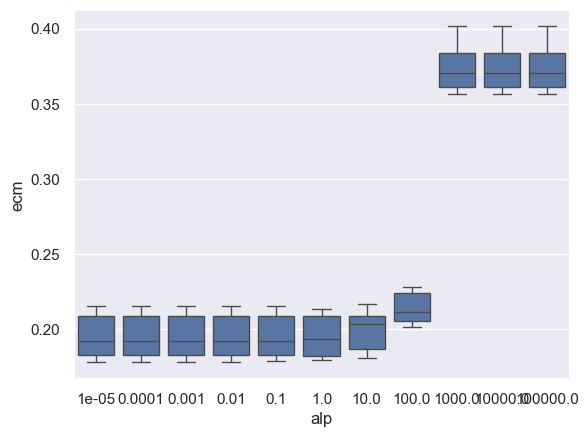

In [34]:
# Box plot para regularización LASSO

import seaborn as sns
sns.set()
ss = sns.boxplot(data=reg_lasso[1], x="alp", y="ecm")

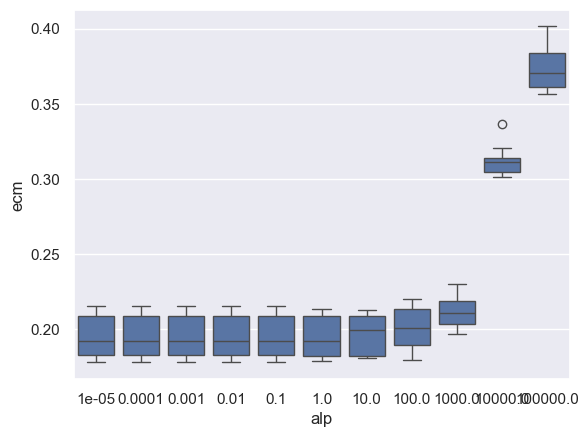

In [35]:
# Box plot para regularización Ridge

sns.set()
ss = sns.boxplot(data=reg_ridge[1], x="alp", y="ecm")

#### Ejercicio 6 

 LASSO elimina todos los coeficientes menos 2. Esto tiene sentido si pensamos que está eligiendo un valor de $\lambda$ alto. Esto significaría que el parámetro C, la inversa de λ, es un valor muy bajo, lo que implica una regularización más fuerte.


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
lasso_best = Lasso(alpha=1)
lasso_best.fit(x_train, y_train)
np.set_printoptions(precision=4, suppress=True)
print(list(zip(lasso_best.coef_, x)))

coeficientes_finales = pd.DataFrame([np.array(x_train.columns), lasso_best.coef_]).T
coeficientes_finales.columns = ['Variable', 'Coeficiente']
print(f"El modelo final cuenta con: {coeficientes_finales[coeficientes_finales['Coeficiente'] != 0].shape[0]} variables")
coeficientes_finales


[(0.0, 'const'), (-0.0, 'H15'), (0.0, 'AGLOMERADO'), (0.0, 'CH03'), (-0.0, 'Sexo'), (-0.004138718666966694, 'CH06'), (0.0, 'CH07'), (0.0, 'CH08'), (-0.0, 'CH09'), (-0.0, 'CH10'), (0.0, 'CH11'), (-0.0, 'CH12'), (0.0, 'CH13'), (-0.0, 'CH15'), (-0.0, 'CH16'), (-0.0, 'NIVEL_ED'), (0.0, 'ESTADO'), (-0.0, 'CAT_OCUP'), (0.0, 'CAT_INAC'), (0.0, 'PP02C1'), (0.0, 'PP02C2'), (0.0, 'PP02C3'), (0.0, 'PP02C4'), (0.0, 'PP02C5'), (0.0, 'PP02C6'), (0.0, 'PP02C7'), (0.0, 'PP02C8'), (0.0, 'PP02E'), (0.0, 'PP02H'), (0.0, 'PP02I'), (-0.0, 'IV1'), (-0.0, 'IV2'), (0.0, 'IV3'), (-0.0, 'IV4'), (0.0, 'IV5'), (0.0, 'IV6'), (0.0, 'IV7'), (0.0, 'IV8'), (0.0, 'IV9'), (0.0, 'IV10'), (0.0, 'IV11'), (-0.0, 'IV12_1'), (-0.0, 'IV12_2'), (-0.0, 'IV12_3'), (-0.0, 'II1'), (0.0, 'II2'), (0.0, 'II3'), (-0.0, 'II3_1'), (0.0, 'II4_1'), (0.0, 'II4_2'), (0.0, 'II4_3'), (-0.0, 'II5'), (0.0, 'II5_1'), (-0.0, 'II6'), (0.0, 'II6_1'), (0.0, 'II7'), (0.0, 'II8'), (0.0, 'II9'), (0.0, 'V1'), (0.0, 'V2'), (0.0, 'V21'), (0.0, 'V22'), (0.0

,Variable,Coeficiente
0,const,0.0
1,H15,-0.0
2,AGLOMERADO,0.0
3,CH03,0.0
4,Sexo,-0.0
...,...,...
84,VII1_2,0.0
85,VII2_1,-0.000226
86,VII2_2,-0.0
87,VII2_3,0.0


Lasso solo mantiene las variables de edad (CH06) y vivienda ubicada cercana a un basural(VII2_1).

Podemos pensar que las variables incluidas en la encuesta son muy colineales, por lo que LASSO elimina todas las variables menos dos.

#### Ejercicio 7 

Comenzamos comparando los métodos de regularización de ridge y lasso:

In [37]:
ridge_best = Ridge(alpha=10)
ridge_best.fit(x_train, y_train)

lasso_mse = mean_squared_error(y_test, lasso_best.predict(x_test))
ridge_mse = mean_squared_error(y_test, ridge_best.predict(x_test))

print("Error cuadrático medio (Lasso): %.2f" % lasso_mse)
print("Error cuadrático medio (Ridge): %.2f" % ridge_mse)

Error cuadrático medio (Lasso): 0.20
Error cuadrático medio (Ridge): 0.13


Como podemos observar en nuestras respuestas anteriores, el error cuadrático medio de ridge es menor. De modo que adoptamos el modelo ridge.  Ahora estimamos el modelo logit para cada uno de los metodos de regularizacion, y comparamos los resultados.

In [38]:
modelos = ["Logit"]
parametros = {"k_range": range(3,5), "penalty": ["l1", "l2"], "lambda": np.logspace(-5,5,num=5-(-5)+1,base=10)} #Penalty de Lasso, la l2 es Ridge.

lasso_7 = evalua_multiples_metodos(modelos,x,y,parametros)

lasso_7[0]


,Modelo,Neighbors,Components,Penalty,Alp_best,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1
0,Logit,,,l1,0.00001,0.820878,0.179122,0.616471,0.787345,501,65,86,191
1,Logit,,,l2,0.00001,0.820878,0.179122,0.616471,0.787345,501,65,86,191


Podemos ver que bajo un valor de $\lambda$ de 0.0001, el modelo logit con regularizacion ridge o lasso son iguales, debido a que estamos un valor extremo de penalizacion. 

#### Ejercicio 8

En base a las tablas presentadas en los incisos anteriores, si nuestra preocupación es minimizar el ECM y mejor la precisión, el mejor método de los analizados es LDA (con 1 componente), ya que el ECM en este caso es de 0.1779, contra un 0.179122 de logit (regularizado por ridge con λ = 0.0001) y 0.22064 de KNN (con 5 vecinos). 

Sin embargo, si nuestro obejtivo fuera identificar hogares pobres para incluirlos en alguna política, nuestro objetivo es  identificar la menor cantidad posible de falsos negativos (no queeeriamos eexluir a alguieen que reealmente es pobre) tambien es LDA con 59. 

Tabmien si nos interesan los verdaderos positivos, LDA es un método superior, ya que identifica 31 verdaderos positivos al observar la matriz de confusión, contra 27 de Logit. 

La cantidad de verdaderos negativos es mayor en Logit, pero  solo difere en 3,por lo que algún análisis costo-beneficio no pareciera ir en contra de la mejor identificación de LDA. 

A su vez, el área debajo de la curva ROC de LDA es de 0.7836, contra un 0.7873 de Logit y 0.7279 en KNN, por lo que marginalmente podemos ver que el método LDA posee una mejor precisión en la clasificación. 

Por esta razón y por lo expuesto en el párrafo anterior, decidimos que el mejor método resulta ser LDA con 1 componente.




#### Ejercicio 9 

Dado que seleccionamos LDA (1 componente) como el mejor, ahora lo utilizamos para predecir fuera de la muestra. Utilizando la base de los que no respondieron sobre su ingreso.

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

lda_final = LinearDiscriminantAnalysis(n_components=1)
lda_final_fit = lda_final.fit(x_train, y_train)

y_pred = lda_final_fit.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

count = np.count_nonzero(y_pred == 1)

print("En base al modelo",lda_final,", la cantidad predicha de hogares pobres para la submuestra es de", count, "personas.")

proporcion = np.count_nonzero(y_pred == 1)/(len(y_pred))
proporcion = proporcion*100
print("La proporción de hogares pobres en la submuestra es del %.2f" % proporcion,"%.")

En base al modelo LinearDiscriminantAnalysis(n_components=1) , la cantidad predicha de hogares pobres para la submuestra es de 245 personas.
La proporción de hogares pobres en la submuestra es del 29.06 %.


Mediante LDA se estima una pobreza ed 29.06% para los que no respondieron, contra un 37.39% de los que respondieron.